# **Loading & Unzipping Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/depression_dataset.zip'

# **Importing Libraries and packages**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.0 MB/s eta 0:00:00


In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=61482721fe62cfe9b8e56710092e1fe1f69d54c254727f067e890838fd365139
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer, BertModel
from sklearn.metrics import classification_report
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from sklearn.utils import class_weight
from torchviz import make_dot
import torch.nn.functional as Func
from nltk.stem import PorterStemmer
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
import itertools
import shutil
import string
import pickle
import torch
import nltk
import json
import re
import os

## **Device Setup**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# **Data Preprocessing & Cleaning**

In [ ]:
# set data paths
image_dir = '/content/content/main_data/img'
train_json_dir = '/content/content/main_data/train.jsonl'
test_dir = '/content/content/main_data/test.jsonl'
dev_dir = '/content/content/main_data/val.jsonl'

In [ ]:
# creating the dataframes for better handling the data
train_data_df = pd.read_json(train_json_dir, lines=True)
test_df = pd.read_json(test_dir, lines=True)
dev_df = pd.read_json(dev_dir, lines=True)

print(f"Train Data Shape: {train_data_df.shape}")
print(f"Test Data Shape: {test_df.shape}")
print(f"Validation Data Shape: {dev_df.shape}")

Train Data Shape: (4380, 4)
Test Data Shape: (548, 4)
Validation Data Shape: (547, 4)


In [ ]:
# text cleaning
def text_cleaning(text):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub("\\W"," ",text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = " ".join(text.split())
  return text

In [ ]:
train_data_df['title'] = train_data_df['title'].apply(text_cleaning)
test_df['title'] = test_df['title'].apply(text_cleaning)
dev_df['title'] = dev_df['title'].apply(text_cleaning)

In [ ]:
train_data_df['label'].value_counts()

1    2496
0    1884
Name: label, dtype: int64

This shows that our dataset is un-balanced, we need to handle this.

In [ ]:
# method to save processed .jsonl file
def save_jsonl(df, name):
  with open("/content/content/main_data/{}.jsonl".format(name), "w") as outfile:
    for _, row in df.iterrows():
      json_str = row.to_json()
      outfile.write(json_str + '\n')

  print("Done")

In [ ]:
save_jsonl(train_data_df, 'train')
save_jsonl(test_df, 'test')
save_jsonl(dev_df, 'val')

Done
Done
Done


# **Creating & Saving DataLoaders**

In [ ]:
# pytorch custom dataset class for hatememe dataset
class DepressionDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = '/content/content/main_data'
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True)
        ])
            
    def __getitem__(self, index: int):
        image = Image.open(os.path.join(self.data_dir, self.data[index]["image"])).convert("RGB")
        image = self.transform(image)
        text = self.data[index]["title"]
        label = torch.tensor(self.data[index]["label"], dtype=torch.long)
        
        return image, text, label

    def load_image_only(self, index: int):
        image = Image.open(os.path.join(self.data_dir, self.data[index]["image"])).convert("RGB")
        image = self.transform(image)
        return image
    
    def get_label(self, index: int):
        label = torch.tensor(self.data[index]["label"], dtype=torch.long)
        return label
    
    def get_test_item(self, index: int):
        image = Image.open(os.path.join(self.data_dir, self.data[index]["image"])).convert("RGB")
        image = self.transform(image)
        text = self.data[index]["title"]
        
        return image, text
    
    def __len__(self):
        return len(self.data)

In [ ]:
# creating dataset objects for train set
train_dataset = DepressionDataset('/content/content/main_data/train.jsonl')

# creating dataset objects for dev set
dev_dataset = DepressionDataset('/content/content/main_data/val.jsonl')

# creating dataset objects for test set
test_dataset = DepressionDataset('/content/content/main_data/test.jsonl')

In [ ]:
# creating data loader for train set
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32)

# creating data loader for validation set
val_loader = torch.utils.data.DataLoader(dataset=dev_dataset, batch_size=32)

# creating data loader for test set
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32)

## **Testing the loader batch**

In [ ]:
images, texts, labels = next(iter(train_loader))
images.shape

torch.Size([32, 3, 224, 224])

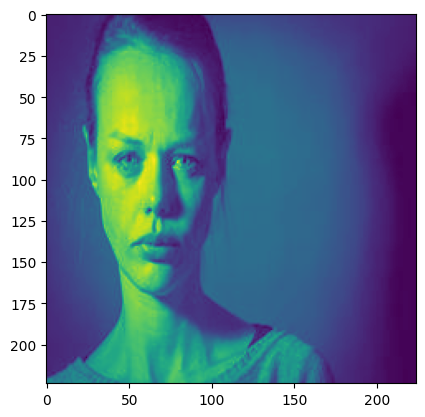

In [ ]:
plt.imshow(images[0][0])

## **Image Grid**

In [ ]:
HATEFUL_LABEL = 0
HATELESS_LABEL = 1

In [ ]:
# showing image grids
def show_image_group(dataset, type, n_images):
  set_ids = [id for id in range(0, len(dataset)) if dataset.get_label(id)==type]
  if type == 1:
    print(f"Depression Meme Count: {len(set_ids)}/{len(dataset)} \n")
  else:
    print(f"Non Depression Meme Count: {len(set_ids)}/{len(dataset)} \n")

  image_ids = set_ids[:n_images]
  images = [dataset.load_image_only(id) for id in image_ids]

  hate_grid = torchvision.utils.make_grid(images, nrow = 5)
  plt.figure(figsize=(15,10))
  plt.axis(False)
  plt.imshow(F.to_pil_image(hate_grid))

Depression Meme Count: 2496/4380 



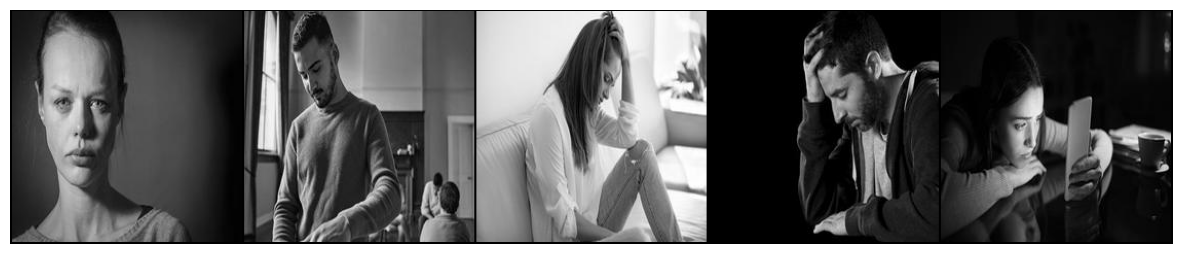

In [ ]:
show_image_group(train_dataset, 1, 5)

Non Depression Meme Count: 1884/4380 



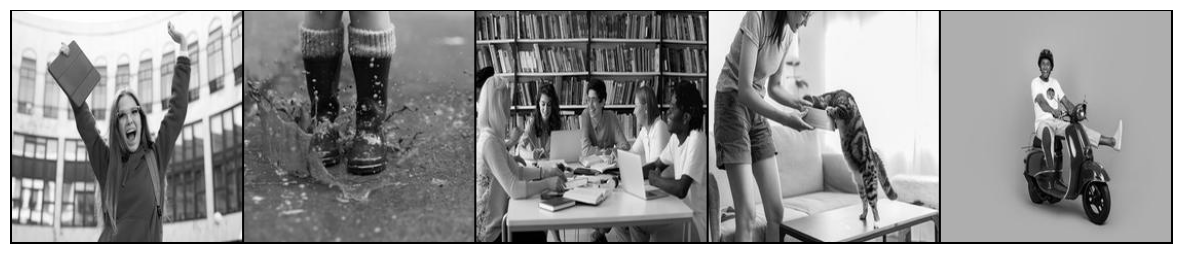

In [ ]:
show_image_group(train_dataset, 0, 5)

# **Setup - 3**

In [ ]:
class DepressionClassifierSetup3(nn.Module):
    def __init__(self, num_epochs, train_loader, val_loader, num_classes=2, dropout = 0.5):
      super(DepressionClassifierSetup3, self).__init__()
      self.num_classes = num_classes
      self.dropout = dropout
      self.num_epochs = num_epochs
      
      # Image model
      self.image_model = models.inception_v3(pretrained = True).to(device)
      self.fc1 = nn.Linear(self.image_model.fc.out_features, 512)
      self.fc2 = nn.Linear(512, 224)
      
      # Text model
      self.text_model = BertModel.from_pretrained('bert-base-uncased')
      self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
      
      # Classifier
      self.classifier = nn.Sequential(
          nn.Linear(224 + 768, 256),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(256, self.num_classes)
      )
      self.criterion = nn.CrossEntropyLoss()

      # data loaders
      self.train_loader = train_loader
      self.val_loader = val_loader

      # loss and accuracy lists
      self.train_loss, self.train_accuracy = [], []
      self.val_loss, self.val_accuracy = [], []


    # forward pass
    def forward(self, images, texts):
      images = Func.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
      images = images.to(device)

      # print(type(self.image_model(images)))
      try:
        image_features = self.image_model(images).logits
      except:
        image_features = self.image_model(images)
        
      image_features = self.fc2(self.fc1(image_features))

      text_input_ids = self.tokenizer(texts, padding=True, truncation=True, return_tensors='pt').input_ids
      text_input_ids = text_input_ids.to(device)

      text_features = self.text_model(input_ids=text_input_ids).last_hidden_state[:, 0, :]
      features = torch.cat([image_features, text_features], dim=1)
      outputs = self.classifier(features)
      return outputs


    # predict method
    def predict(self, image, text):
      image = torch.reshape(image, (1, 3, 224, 224))
      output = self(image, text)
      print(output)
      predicted_class = torch.softmax(output, dim=1).argmax(dim=1)
      return predicted_class


    def train_model(self, optimizer):
      n_total_steps = len(self.train_loader)

      for epoch in range(self.num_epochs):
        # training section
        self.train()
        running_loss, n_correct, n_samples = 0.0, 0, 0

        for index, (images, texts, labels) in enumerate(self.train_loader):
          # Forward pass
          images = images.to(device)
          labels = labels.to(device)

          outputs = self(images, texts)
          loss = self.criterion(outputs, labels)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = torch.max(outputs, 1)

          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()

          if (index+1) % 266 == 0:
            print(f'Epoch --> [{epoch+1}/{num_epochs}] | Step --> [{index+1}/{n_total_steps}] | Loss --> {loss.item():.4f} | Accuracy --> {n_correct/n_samples:.4f}')

        training_loss = running_loss/n_total_steps
        accuracy = 100.0 * n_correct / n_samples

        self.train_loss.append(round(training_loss, 4))
        self.train_accuracy.append(accuracy)

        # validation section, as we have activated the model in the evaluation mode using .eval()
        self.eval()
        running_val_loss = 0.0
        n_correct, n_samples = 0.0, 0.0

        with torch.no_grad():
          for batch_index, (images, texts, labels) in enumerate(self.val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = self(images, texts)
            val_loss = self.criterion(outputs, labels)

            running_val_loss += val_loss.item()
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

          avg_val_loss = running_val_loss / len(self.val_loader)
          accuracy = 100.0 * n_correct / n_samples

          self.val_loss.append(avg_val_loss)
          self.val_accuracy.append(accuracy)

      print(f"\nValidation Accuracy of the Network: {sum(self.val_accuracy)/self.num_epochs} %\n")
      print("Training Complete !!")
      return True


    def test_model(self, loader):
      # test_loss, test_accuracy = [], []
      predicted_labels, actual_labels = [], []

      self.eval()
      running_test_loss = 0.0
      n_correct, n_samples = 0.0, 0.0

      with torch.no_grad():
        for batch_index, (images, texts, labels) in enumerate(loader):
          images = images.to(device)
          labels = labels.to(device)

          outputs = self(images, texts)
          temp_test_loss = self.criterion(outputs, labels)

          running_test_loss += temp_test_loss.item()

          _, predicted = torch.max(outputs, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()

          predicted_labels.append(list(predicted))
          actual_labels.append(list(labels))

      avg_test_loss = running_test_loss / len(loader)
      accuracy = 100.0 * n_correct / n_samples

      predicted_labels = list(itertools.chain(*predicted_labels))
      actual_labels = list(itertools.chain(*actual_labels))

      self.train()
      print(f"Test Accuracy of the Network: {accuracy} %\n")
      return predicted_labels, actual_labels
      

    # utility method for plotting loss and epochs
    def plot_loss_vs_epoch(self):
        plt.figure()
        plt.plot(range(self.num_epochs), self.val_loss, 'b', label = 'Validation Loss')
        plt.plot(range(self.num_epochs), self.train_loss, 'r', label = 'Training Loss')
        plt.xlabel("Number of Epochs")
        plt.ylabel("Loss")
        plt.title("EPOCH VS LOSS PLOT")
        plt.legend()
        plt.grid()
        plt.show()


    # utility method for plotting accuracies and epochs
    def plot_accuracy_vs_epoch(self):
        plt.figure()
        plt.plot(range(self.num_epochs), self.val_accuracy, 'b', label = 'Validation Accuracy')
        plt.plot(range(self.num_epochs), self.train_accuracy, 'r', label = 'Training Accuracy')
        plt.xlabel("Number of Epochs")
        plt.ylabel("Accuracy")
        plt.title("EPOCH VS ACCURACY PLOT")
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
classifierSetup3 = DepressionClassifierSetup3(num_epochs, train_loader, val_loader, dropout=dropout).to(device)
optimizer = torch.optim.Adam(classifierSetup3.parameters(), lr=1e-5, weight_decay=0.01)

In [ ]:
classifierSetup3.train_model(optimizer)


Validation Accuracy of the Network: 98.06215722120659 %

Training Complete !!


True

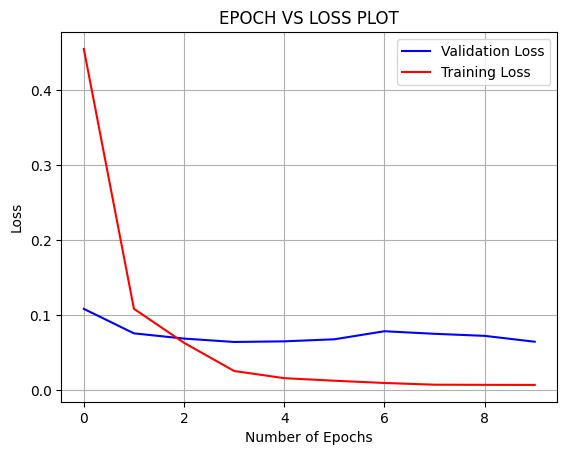

In [ ]:
classifierSetup3.plot_loss_vs_epoch()

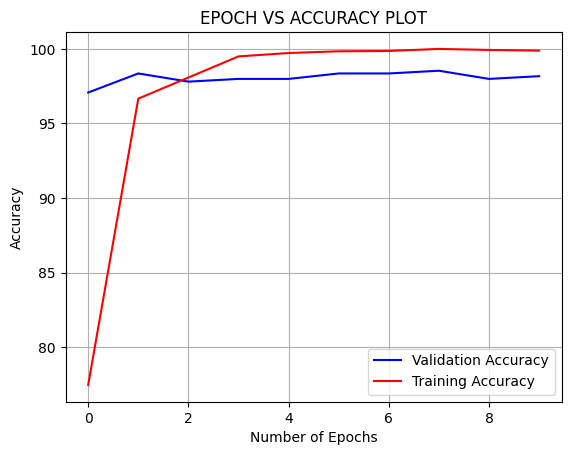

In [ ]:
classifierSetup3.plot_accuracy_vs_epoch()

In [ ]:
torch.save(classifierSetup3, 'ir_project_model_3.pth')
shutil.copy('/content/ir_project_model_3.pth', '/content/drive/MyDrive/IR Project')

'/content/drive/MyDrive/IR Project/ir_project_model_3.pth'

In [ ]:
predicted, actual = classifierSetup3.test_model(test_loader)

Test Accuracy of the Network: 96.89781021897811 %



In [ ]:
predicted = np.array([tensor.cpu().numpy() for tensor in predicted])
actual =  np.array([tensor.cpu().numpy() for tensor in actual])

In [ ]:
print(classification_report(predicted, actual))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       233
           1       0.98      0.97      0.97       315

    accuracy                           0.97       548
   macro avg       0.97      0.97      0.97       548
weighted avg       0.97      0.97      0.97       548

